In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
torch.cuda.empty_cache()

In [3]:
df = pd.read_csv("dataset/NYCTaxiFares.csv")

In [4]:
df.head(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


In [6]:
def haversine(df, lat1, long1, lat2, long2):
    r = 6371
    
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2] - df[long1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    
    return d

In [7]:
df['distance'] = haversine(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [8]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [9]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [10]:
df['Hour'] = df['EDTdate'].dt.hour
df['Meridian'] = np.where(df['Hour']<12, 'am', 'pm')

In [11]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [12]:
LABELS = df['fare_class'].unique()

In [13]:
df.head(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,Meridian,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [14]:
cat_cols = ['Hour', 'Meridian', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']

In [15]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [16]:
std_scaler = StandardScaler()

In [17]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)

In [18]:
cats = torch.tensor(cats, dtype=torch.int64).cuda()

In [19]:
conts = np.stack([df[col].values for col in cont_cols], axis=1)

In [20]:
conts = std_scaler.fit_transform(conts)

In [21]:
conts = torch.tensor(conts, dtype=torch.float).cuda()

In [22]:
labels = torch.tensor(df['fare_class'].values).flatten().cuda()

In [23]:
cat_size = [len(df[col].cat.categories) for col in cat_cols]

In [24]:
embedding_size = [(size, min(50, (size+1)//2)) for size in cat_size]

In [25]:
class TabularModel(nn.Module):
    def __init__(self, embedding_size, n_cont, out, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in embedding_size])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm = nn.BatchNorm1d(n_cont)
        
        layer_list = []
        n_embs = sum([nf for ni, nf in embedding_size])
        n_in = n_embs + n_cont
        
        for layer in layers:
            layer_list.append(nn.Linear(n_in, layer))
            layer_list.append(nn.LeakyReLU(negative_slope=0.3, inplace=True))
            layer_list.append(nn.BatchNorm1d(layer))
            layer_list.append(nn.Dropout(p))
            n_in = layer
        
        layer_list.append(nn.Linear(layers[-1], out))
        
        self.layers = nn.Sequential(*layer_list)
            
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
        
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.batch_norm(x_cont)
        
        x = torch.cat([x, x_cont], axis=1)
        x = self.layers(x)
        
        return x        

In [26]:
model = TabularModel(embedding_size, conts.shape[1], 2, [224, 128], p=0.4).cuda()

In [27]:
criterion = nn.CrossEntropyLoss().cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1000
batch_size = 60000
test_size = int(batch_size*0.2)
losses = []
val_losses = []
acc = []
val_acc = []

In [28]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]

In [29]:
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

In [30]:
start_time = time.time()

for e in range(epochs):
    e_start = time.time()
    
    y_hat = model(cat_train, cont_train)
    loss = criterion(y_hat, y_train)
    losses.append(loss)
    
    pred = torch.max(y_hat.data, 1)[1]
    pred = (pred == y_train).sum()
    accuracy = (pred.item()*100)/len(y_train)
    acc.append(accuracy)
    
    with torch.no_grad():
        y_valid = model(cat_test, cont_test)
        val_loss = criterion(y_valid, y_test)
        val_losses.append(val_loss)
        
        val_pred = torch.max(y_valid.data, 1)[1]
        val_pred = (val_pred == y_test).sum()
        val_accuracy = (val_pred.item()*100)/len(y_test)
        val_acc.append(val_accuracy)
        
    # display training metrics
    if (e % 100 == 0) or e==0 or e==(epochs-1):
        e_end = time.time()
        print("Epoch {}".format(e+1))
        print("Accuracy: {:2.2f} % | Loss: {:2.4f} | Validation Accuracy: {:2.2f} | Validation Loss: {:2.4f} | Duration: {:2.2f} minutes".format(accuracy, loss, val_accuracy, val_loss, ((e_end - e_start)/60)))
    
    # back propagation
    optim.zero_grad()
    loss.backward()
    optim.step()

end_time = time.time() - start_time

print("\nTraining Duration {:.4f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1
Accuracy: 47.86 % | Loss: 0.8269 | Validation Accuracy: 48.05 | Validation Loss: 0.8235 | Duration: 0.03 minutes
Epoch 101
Accuracy: 88.45 % | Loss: 0.3033 | Validation Accuracy: 88.86 | Validation Loss: 0.2894 | Duration: 0.00 minutes
Epoch 201
Accuracy: 89.40 % | Loss: 0.2829 | Validation Accuracy: 89.43 | Validation Loss: 0.2731 | Duration: 0.00 minutes
Epoch 301
Accuracy: 89.86 % | Loss: 0.2711 | Validation Accuracy: 90.16 | Validation Loss: 0.2631 | Duration: 0.00 minutes
Epoch 401
Accuracy: 90.24 % | Loss: 0.2601 | Validation Accuracy: 90.64 | Validation Loss: 0.2534 | Duration: 0.00 minutes
Epoch 501
Accuracy: 90.52 % | Loss: 0.2554 | Validation Accuracy: 90.66 | Validation Loss: 0.2519 | Duration: 0.00 minutes
Epoch 601
Accuracy: 90.64 % | Loss: 0.2523 | Validation Accuracy: 90.78 | Validation Loss: 0.2469 | Duration: 0.00 minutes
Epoch 701
Accuracy: 90.66 % | Loss: 0.2522 | Validation Accuracy: 90.94 | Validation Loss: 0.2446 | Duration: 0.00 minutes
Epoch 801
Accuracy

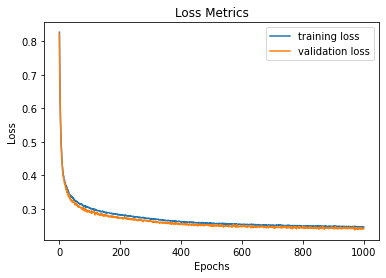

In [31]:
plt.plot(range(epochs), losses, label='training loss')
plt.plot(range(epochs), val_losses, label='validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show() 

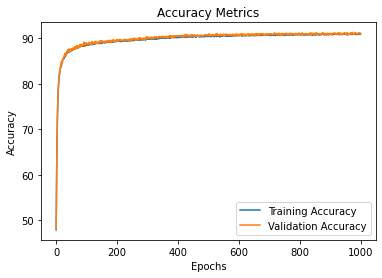

In [32]:
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [33]:
torch.cuda.empty_cache()

In [34]:
model.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (batch_norm): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=224, bias=True)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): BatchNorm1d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=224, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [35]:
with torch.no_grad():
    correct = 0
    y_val = model(cat_test, cont_test)
    test_loss = criterion(y_val, y_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()
    print(f"Test Accuracy: {(correct.item()*100)/len(y_test):.2f} % | Test Loss: {test_loss:.4f}")

con_mat = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())    
print(f"\nConfusion Matrix\n\n{con_mat}")

Test Accuracy: 91.65 % | Test Loss: 0.2295

Confusion Matrix

[[7592  393]
 [ 609 3406]]


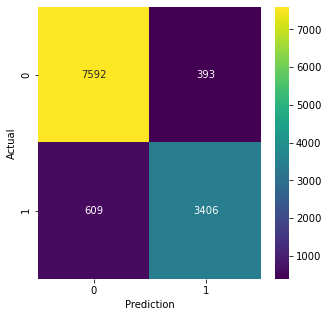

In [36]:
df_cm = pd.DataFrame(con_mat, LABELS, LABELS)
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [37]:
print(f"Classification Report\n\n{classification_report(y_test.view(-1).cpu(), predicted.view(-1).cpu())}")

Classification Report

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7985
           1       0.90      0.85      0.87      4015

    accuracy                           0.92     12000
   macro avg       0.91      0.90      0.90     12000
weighted avg       0.92      0.92      0.92     12000



In [38]:
torch.save(model.state_dict(), 'models/taxi_classifier.pt')